## 0. Introduction
this notebook shows the model training inculding spliting, sloving imblance cat. and training and eval.


In [101]:
!pip install imbalanced-learn

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

## 1. Load Data

In [104]:
df = pd.read_csv("../data/cleaned_telecom_churn_data.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]  # encode target

## 2. Identify feature types

In [105]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaymentMethod"
]

## 3. Preprocessing pipeline

In [106]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

## 4. Model Training Experiments

### 4.1. Split Data

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

### 4.2. Define Models

In [108]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

### 4.3. Experiment A: Baseline Models

In [109]:
expA_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    expA_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "Original"
    })

expA_results = pd.DataFrame(expA_results)
display(expA_results)

,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.795261,0.586998,0.547237,0.632990,Original
1,SVC,0.788152,0.545270,0.477718,0.635071,Original
2,RandomForest,0.767773,0.523346,0.479501,0.576017,Original
3,GradientBoosting,0.782938,0.541082,0.481283,0.617849,Original
4,XGBoost,0.767773,0.534221,0.500891,0.572301,Original


### 4.4. Experiment B: Cross-Validation and Hyperparameter Tuning

In [110]:
param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

X_train_orig, y_train_orig = X_train, y_train

In [112]:
expB_results = []

for name, model in models.items():
    print(f"\nRunning GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1')
    grid_search.fit(X_train_orig, y_train_orig)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    expB_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "CV + Hyperparam"
    })

expB_results = pd.DataFrame(expB_results)
display(expB_results)


Running GridSearchCV for LogisticRegression...

Running GridSearchCV for SVC...

Running GridSearchCV for RandomForest...

Running GridSearchCV for GradientBoosting...

Running GridSearchCV for XGBoost...


,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.792891,0.583413,0.545455,0.627049,CV + Hyperparam
1,SVC,0.794313,0.579457,0.532977,0.634820,CV + Hyperparam
2,RandomForest,0.787678,0.555556,0.499109,0.626398,CV + Hyperparam
3,GradientBoosting,0.783412,0.540704,0.479501,0.619816,CV + Hyperparam
4,XGBoost,0.790047,0.552977,0.488414,0.637209,CV + Hyperparam


### 4.5. Experiment C: Addressing Class Imbalance

In [113]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_orig, y_train_orig)

In [114]:
y_train_bal.value_counts()

Churn
1    3614
0    3614
Name: count, dtype: int64

In [115]:
expC_results = []

for name, model in models.items():
    print(f"\nRunning Balanced Experiment for {name}...")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    expC_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "Precision": precision,
        "Experiment": "Balanced"
    })

expC_results = pd.DataFrame(expC_results)
display(expC_results)


Running Balanced Experiment for LogisticRegression...

Running Balanced Experiment for SVC...

Running Balanced Experiment for RandomForest...

Running Balanced Experiment for GradientBoosting...

Running Balanced Experiment for XGBoost...


,Model,Accuracy,F1,Recall,Precision,Experiment
0,LogisticRegression,0.735071,0.614217,0.793226,0.501126,Balanced
1,SVC,0.743128,0.618310,0.782531,0.511059,Balanced
2,RandomForest,0.757820,0.553712,0.565062,0.542808,Balanced
3,GradientBoosting,0.769668,0.631259,0.741533,0.549538,Balanced
4,XGBoost,0.761611,0.580484,0.620321,0.545455,Balanced


## 5. Comparing Results and Selecting the Best Model

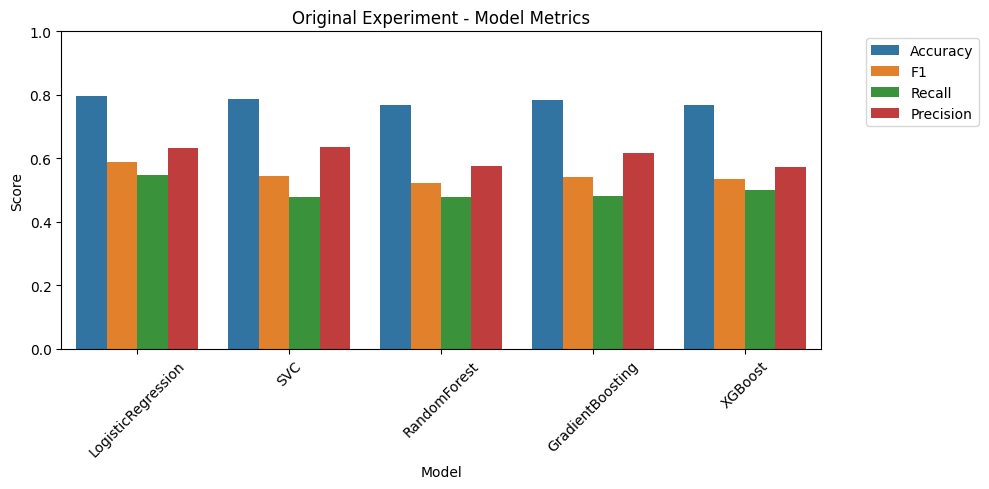

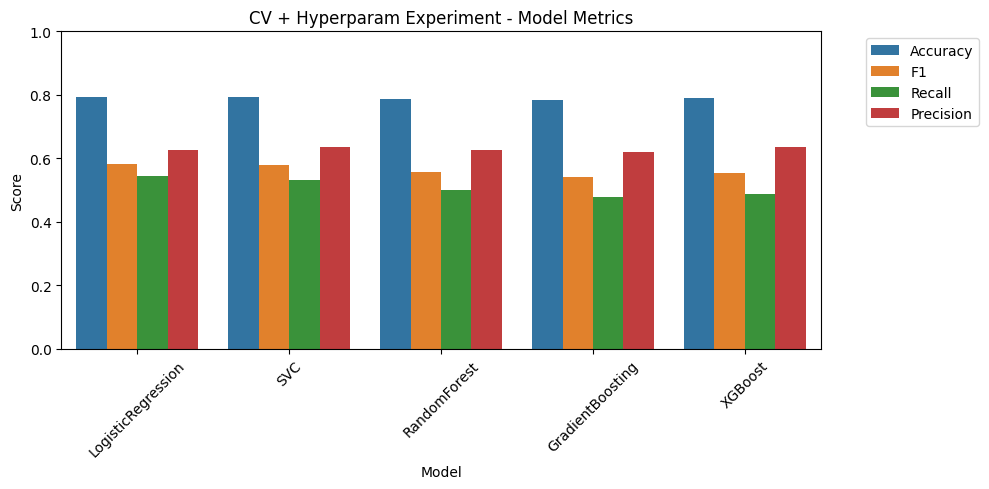

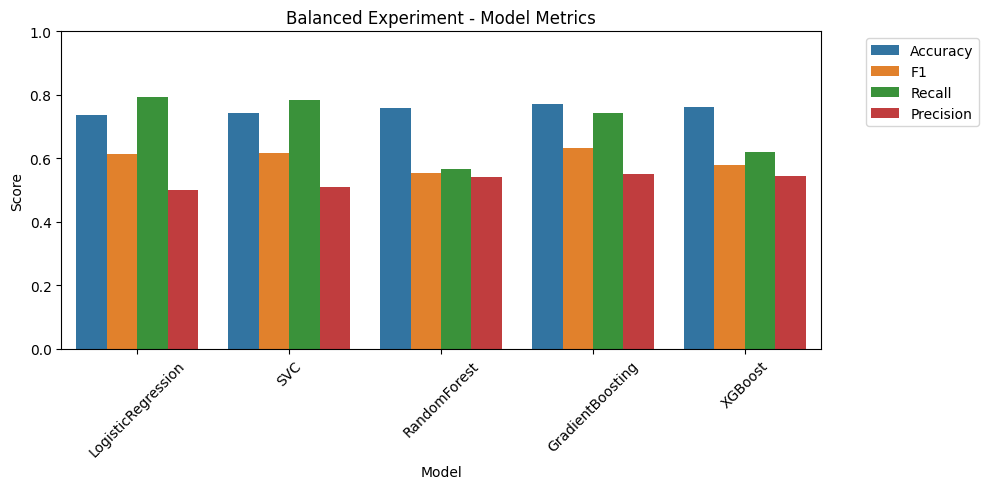

In [116]:
# Combine experiments in a dictionary for easy iteration
experiment_dict = {
    "Original": expA_results,
    "CV + Hyperparam": expB_results,
    "Balanced": expC_results
}

# Iterate through experiments
for exp_name, df_exp in experiment_dict.items():

    # Melt for seaborn plotting
    df_melted = df_exp.melt(
        id_vars=["Model"],
        value_vars=["Accuracy", "F1", "Recall", "Precision"],
        var_name="Metric",
        value_name="Score"
    )

    # Plot
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
    plt.title(f"{exp_name} Experiment - Model Metrics")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [117]:
all_results = pd.concat([expA_results, expB_results, expC_results])

# Identify the best model based on F1-score, prioritizing the balanced experiment results if available
best_model_expC = expC_results.loc[expC_results['F1'].idxmax()]
best_model_expB = expB_results.loc[expB_results['F1'].idxmax()]
best_model_expA = expA_results.loc[expA_results['F1'].idxmax()]

print("\n--- Best Model Selection ---")
print("Best F1-score from Balanced Experiment (Experiment C):")
display(best_model_expC)

print("\nBest F1-score from CV + Hyperparam Experiment (Experiment B):")
display(best_model_expB)

print("\nBest F1-score from Original Experiment (Experiment A):")
display(best_model_expA)



--- Best Model Selection ---
Best F1-score from Balanced Experiment (Experiment C):


Model         GradientBoosting
Accuracy              0.769668
F1                    0.631259
Recall                0.741533
Precision             0.549538
Experiment            Balanced
Name: 3, dtype: object


Best F1-score from CV + Hyperparam Experiment (Experiment B):


Model         LogisticRegression
Accuracy                0.792891
F1                      0.583413
Recall                  0.545455
Precision               0.627049
Experiment       CV + Hyperparam
Name: 0, dtype: object


Best F1-score from Original Experiment (Experiment A):


Model         LogisticRegression
Accuracy                0.795261
F1                      0.586998
Recall                  0.547237
Precision                0.63299
Experiment              Original
Name: 0, dtype: object

## 6. Save the Best Model